# Importing libraries

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, Normalizer, LabelEncoder

# Fetching data

## Public agents' file

In [2]:
path = '../cmd/data/cache/Remuneracao.txt'

df = pd.read_csv(path, sep=';', encoding='latin1', decimal=',')
df.head()

,NOME,CARGO,ORGÃO,REMUNERAÇÃO DO MÊS,FÉRIAS E 13º SALÁRIO,PAGAMENTOS EVENTUAIS,LICENÇA PRÊMIO INDENIZADA,ABONO PERMANÊNCIA & OUTRAS INDENIZAÇÕES,REDUTOR SALARIAL,TOTAL LIQUÍDO (R$)
0,AAIRON TELES DE CAMARGO,OFICIAL ADMINISTRATIVO,DEPTO. EST. TRANSITO DETRAN SP,2396.86,0.0,0.0,0.0,182.98,0.0,2221.67
1,AALAN DA SILVA ARAUJO,SD 1C PM,POLICIA MILITAR SAO PAULO,3497.00,0.0,0.0,0.0,742.84,0.0,2543.61
2,AARAN ESTEVAO LIMA BARBOSA,1TEN PM,POLICIA MILITAR SAO PAULO,9431.06,0.0,0.0,0.0,504.07,0.0,7011.47
3,AARAO DE OLIVEIRA,MAJ PM,SPPREV,14353.19,0.0,0.0,0.0,0.00,0.0,11084.72
4,AARON DE OLIVEIRA BARBOSA,AGENTE TECNICO ASSIST. A SAUDE,HOSP.CLIN.FAC.MED.USP-HCFMUSP,5253.07,0.0,0.0,0.0,0.00,0.0,4414.52


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077512 entries, 0 to 1077511
Data columns (total 10 columns):
NOME                                       1077512 non-null object
CARGO                                      1077512 non-null object
ORGÃO                                      1077512 non-null object
REMUNERAÇÃO DO MÊS                         1077512 non-null float64
FÉRIAS E 13º SALÁRIO                       1077512 non-null float64
PAGAMENTOS EVENTUAIS                       1077512 non-null float64
LICENÇA PRÊMIO INDENIZADA                  1077512 non-null float64
ABONO PERMANÊNCIA & OUTRAS INDENIZAÇÕES    1077512 non-null float64
REDUTOR SALARIAL                           1077512 non-null float64
TOTAL LIQUÍDO (R$)                         1077512 non-null float64
dtypes: float64(7), object(3)
memory usage: 82.2+ MB


## Customer's list

In [4]:
path_clientes = '../cmd/data/cache/clientes.csv'
df_clientes = pd.read_csv(path_clientes, header=None)
list_clientes = df_clientes[0].tolist()

# Preprocessing

## making target

In [5]:
df['is_customer'] = df.NOME.isin(list_clientes)
df.is_customer.sum()

195

## undersample

In [6]:
train = df[df.is_customer == 0].sample(200)
train = train.append(df[df.is_customer == 1])


In [7]:
train.is_customer.value_counts()

False    200
True     195
Name: is_customer, dtype: int64

## Train test split

In [8]:
X = train.drop(['is_customer', 'NOME'], axis=1)
y = train.is_customer

In [9]:
pd.isna(X).sum()

CARGO                                      0
ORGÃO                                      0
REMUNERAÇÃO DO MÊS                         0
FÉRIAS E 13º SALÁRIO                       0
PAGAMENTOS EVENTUAIS                       0
LICENÇA PRÊMIO INDENIZADA                  0
ABONO PERMANÊNCIA & OUTRAS INDENIZAÇÕES    0
REDUTOR SALARIAL                           0
TOTAL LIQUÍDO (R$)                         0
dtype: int64

In [10]:
pd.isna(y).sum()

0

## Label encoding

In [11]:
lb = LabelBinarizer()
lb.fit(y)
y = lb.transform(y)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 131335 to 1056458
Data columns (total 9 columns):
CARGO                                      395 non-null object
ORGÃO                                      395 non-null object
REMUNERAÇÃO DO MÊS                         395 non-null float64
FÉRIAS E 13º SALÁRIO                       395 non-null float64
PAGAMENTOS EVENTUAIS                       395 non-null float64
LICENÇA PRÊMIO INDENIZADA                  395 non-null float64
ABONO PERMANÊNCIA & OUTRAS INDENIZAÇÕES    395 non-null float64
REDUTOR SALARIAL                           395 non-null float64
TOTAL LIQUÍDO (R$)                         395 non-null float64
dtypes: float64(7), object(2)
memory usage: 30.9+ KB


In [12]:
le = LabelEncoder()
X.CARGO = le.fit_transform(X.CARGO)
X['ORGÃO'] = le.fit_transform(X['ORGÃO'])

In [13]:
# X = pd.get_dummies(X)

## Normalize

In [14]:
norm = Normalizer()
X = norm.fit_transform(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# Model

In [16]:
from xgboost import XGBClassifier

In [17]:
%time
xgb = XGBClassifier()
xgb.fit(X_train, y_train.ravel())

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 15 µs


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [18]:
y_pred = xgb.predict(X_test)

/home/gui/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Accuracy

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
accuracy_score(y_test, y_pred)

0.47474747474747475

In [21]:
y_proba = xgb.predict_proba(X_test)

In [22]:
import matplotlib.pyplot as plt


In [23]:
df_proba = pd.DataFrame(y_proba)
df_proba.head()

,0,1
0,0.439333,0.560667
1,0.658463,0.341537
2,0.655154,0.344846
3,0.412402,0.587598
4,0.681006,0.318994


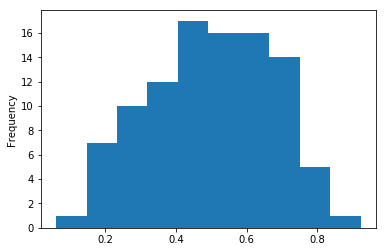

In [24]:
df_proba[0].plot(kind='hist')